In [20]:
# --- Import Important modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import  XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
# load data
our_data = pd.read_csv("D:/Diabeties Project V2/data/diabetes_prediction_dataset.csv")

In [3]:
our_data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
round(our_data['diabetes'].value_counts(normalize=True)*100)

diabetes
0    92.0
1     8.0
Name: proportion, dtype: float64

In [5]:
our_data.shape

(100000, 9)

In [7]:
our_data['age'].max()

80.0

In [6]:
our_data['blood_glucose_level'].max()

300

In [8]:
our_data['bmi'].max()

95.69

In [ ]:
# Seperate the data
X = our_data.drop('diabetes', axis=1)
y = our_data['diabetes']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# --- Preprocessing Setup
categorical_features = ['gender', 'smoking_history']
columns_to_scale = ['age', 'bmi', 'blood_glucose_level']

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe_cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features),
        ('scale_num', StandardScaler(), columns_to_scale)
    ],
    remainder='passthrough'  # Keep other columns
)

In [15]:
# --- Handle class imbalance
neg, pos = y.value_counts()
scale_weight = neg / pos

In [17]:
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    scale_pos_weight=scale_weight,
    objective='binary:hinge',
    use_label_encoder=False,
    random_state=42
)

In [24]:
# Wrap preprocessing in a pipeline step
pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', model)
])

In [25]:
# --- Train the model
pipe.fit(X_train, y_train)

C:\Users\rohit\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:17:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rohit\miniconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender',
                                                   'smoking_history']),
                                                 ('scale_num', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'blood_glucose_level'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, cols...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [26]:
# --- Evaluate the model
y_pred = pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9723

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       0.99      0.68      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000


Confusion Matrix:
 [[18286     6]
 [  548  1160]]


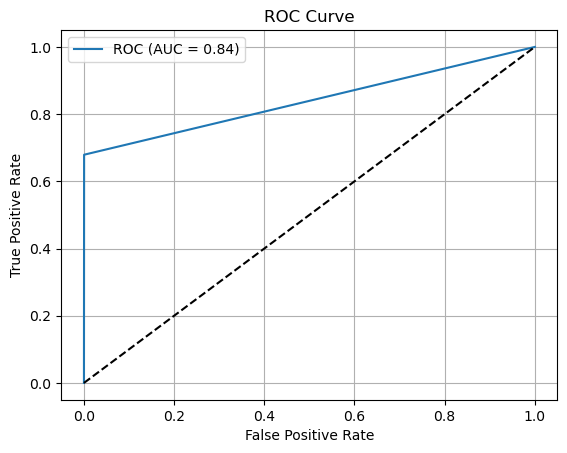

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_probs = pipe.predict_proba(X_test)[:, 1]

# Calculate FPR, TPR for ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

# Plot ROC
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()